# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=10,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-02-37/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4560 | MulticlassF1Score=0.1267
Batch-30 : CrossEntropyLoss=2.4790 | MulticlassF1Score=0.1903
Batch-45 : CrossEntropyLoss=2.4771 | MulticlassF1Score=0.2126
Batch-60 : CrossEntropyLoss=2.4368 | MulticlassF1Score=0.2254
Batch-75 : CrossEntropyLoss=2.4471 | MulticlassF1Score=0.2384
Batch-90 : CrossEntropyLoss=2.4570 | MulticlassF1Score=0.2485
Batch-105: CrossEntropyLoss=2.4511 | MulticlassF1Score=0.2563
Batch-120: CrossEntropyLoss=2.4574 | MulticlassF1Score=0.2612
Batch-135: CrossEntropyLoss=2.4538 | MulticlassF1Score=0.2696
Batch-150: CrossEntropyLoss=2.4549 | MulticlassF1Score=0.2831
Batch-165: CrossEntropyLoss=2.4298 | MulticlassF1Score=0.2964
Batch-180: CrossEntropyLoss=2.4031 | MulticlassF1Score=0.3105
Batch-195: CrossEntropyLoss=2.4121 | MulticlassF1Score=0.3227
Batch-210: CrossEntropyLoss=2.4015 | MulticlassF1Score=0.3377
Batch-225: CrossEntropyLoss=2.3918 | MulticlassF1Score=0.3539
Batch-226: CrossEntropyLoss=2.3872 | MulticlassF1Score=0.3547

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3708 | MulticlassF1Score=0.5806
Batch-30 : CrossEntropyLoss=2.3733 | MulticlassF1Score=0.5784
Batch-45 : CrossEntropyLoss=2.3684 | MulticlassF1Score=0.5782
Batch-60 : CrossEntropyLoss=2.3913 | MulticlassF1Score=0.5785
Batch-63 : CrossEntropyLoss=2.3887 | MulticlassF1Score=0.5786

Training   : Mean CrossEntropyLoss = 2.4570 | Mean MulticlassF1Score = 0.2534
Validation : Mean CrossEntropyLoss = 2.3802 | Mean MulticlassF1Score = 0.5787

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3893 | MulticlassF1Score=0.5872
Batch-30 : CrossEntropyLoss=2.3625 | MulticlassF1Score=0.5862
Batch-45 : CrossEntropyLoss=2.3477 | MulticlassF1Score=0.5985
Batch-60 : CrossEntropyLoss=2.3543 | MulticlassF1Score=0.6092
Batch-75 : CrossEntropyLoss=2.3433 | MulticlassF1Score=0.6164
Batch-90 : CrossEntropyLoss=2.3404 | MulticlassF1Score=0.6337
Batch-105: CrossEntropyLoss=2.3119 | MulticlassF1Score=0.6532
Batch-120: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.6691
Batch-135: CrossEntropyLoss=2.3228 | MulticlassF1Score=0.6815
Batch-150: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.6918
Batch-165: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.7006
Batch-180: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7081
Batch-195: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7143
Batch-210: CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7191
Batch-225: CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7235
Batch-226: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7237

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7849
Batch-30 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7888
Batch-45 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7906
Batch-60 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7894
Batch-63 : CrossEntropyLoss=2.3366 | MulticlassF1Score=0.7890

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3346 | Mean MulticlassF1Score = 0.6553
Validation : Mean CrossEntropyLoss = 2.3142 | Mean MulticlassF1Score = 0.7866

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3230 | MulticlassF1Score=0.7915
Batch-30 : CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7888
Batch-45 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7883
Batch-60 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7878
Batch-75 : CrossEntropyLoss=2.3218 | MulticlassF1Score=0.7886
Batch-90 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7918
Batch-105: CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7930
Batch-120: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7946
Batch-135: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.7949
Batch-150: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7953
Batch-165: CrossEntropyLoss=2.3141 | MulticlassF1Score=0.7955
Batch-180: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7966
Batch-195: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7972
Batch-210: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.7987
Batch-225: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.7996
Batch-226: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7995

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8022
Batch-30 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8038
Batch-45 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8041
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8043
Batch-63 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8050

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3102 | Mean MulticlassF1Score = 0.7934
Validation : Mean CrossEntropyLoss = 2.3087 | Mean MulticlassF1Score = 0.8023

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8024
Batch-30 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8056
Batch-45 : CrossEntropyLoss=2.3214 | MulticlassF1Score=0.8087
Batch-60 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8093
Batch-75 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8091
Batch-90 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8092
Batch-105: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8090
Batch-120: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8101
Batch-135: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8090
Batch-150: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8085
Batch-165: CrossEntropyLoss=2.3184 | MulticlassF1Score=0.8083
Batch-180: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8076
Batch-195: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8080
Batch-210: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8082
Batch-225: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.8078
Batch-226: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.8078

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8149
Batch-30 : CrossEntropyLoss=2.3157 | MulticlassF1Score=0.8069
Batch-45 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8081
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8083
Batch-63 : CrossEntropyLoss=2.3300 | MulticlassF1Score=0.8077

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3073 | Mean MulticlassF1Score = 0.8078
Validation : Mean CrossEntropyLoss = 2.3078 | Mean MulticlassF1Score = 0.8102

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8051
Batch-30 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8072
Batch-45 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8071
Batch-60 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8095
Batch-75 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8096
Batch-90 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8126
Batch-105: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8140
Batch-120: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8171
Batch-135: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8183
Batch-150: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8194
Batch-165: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8207
Batch-180: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8219
Batch-195: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8226
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8232
Batch-225: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8235
Batch-226: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8236

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8358
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8319
Batch-45 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8301
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8286
Batch-63 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8284

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3023 | Mean MulticlassF1Score = 0.8146
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8324

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8328
Batch-30 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8350
Batch-60 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8345
Batch-75 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.8325
Batch-90 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8328
Batch-105: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8318
Batch-120: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8327
Batch-135: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8330
Batch-150: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8330
Batch-165: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8326
Batch-180: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8325
Batch-195: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8325
Batch-210: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8323
Batch-225: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8322
Batch-226: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8232
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8256
Batch-45 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8290
Batch-63 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8296

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8329
Validation : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8250

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8271
Batch-30 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8318
Batch-45 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8358
Batch-60 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8378
Batch-75 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8384
Batch-90 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8394
Batch-105: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8403
Batch-120: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8395
Batch-135: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8400
Batch-150: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8402
Batch-165: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8402
Batch-180: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8404
Batch-195: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8402
Batch-210: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8403
Batch-225: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8404
Batch-226: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8435
Batch-30 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8406
Batch-45 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8387
Batch-60 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8383
Batch-63 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8377

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2969 | Mean MulticlassF1Score = 0.8381
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8415

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8422
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8461
Batch-60 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8448
Batch-75 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8436
Batch-90 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8438
Batch-105: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8432
Batch-120: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8432
Batch-135: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8433
Batch-150: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8448
Batch-165: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8458
Batch-180: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8469
Batch-195: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8476
Batch-210: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8482
Batch-225: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8490
Batch-226: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8491

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8554
Batch-30 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8543
Batch-45 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8536
Batch-60 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8545

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2944 | Mean MulticlassF1Score = 0.8445
Validation : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8550

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8626
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8616
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8609
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8603
Batch-75 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8600
Batch-90 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8593
Batch-105: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8591
Batch-120: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8595
Batch-135: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8597
Batch-150: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8591
Batch-165: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8596
Batch-180: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8596
Batch-195: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8600
Batch-210: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8600
Batch-225: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8601
Batch-226: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8601

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8585
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8585
Batch-45 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8563
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8564
Batch-63 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8566

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2910 | Mean MulticlassF1Score = 0.8603
Validation : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8562

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8667
Batch-30 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8613
Batch-45 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8630
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8623
Batch-75 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8626
Batch-90 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8634
Batch-105: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8635
Batch-120: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8632
Batch-135: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8633
Batch-150: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8631
Batch-165: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8632
Batch-180: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8636
Batch-195: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8639
Batch-210: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8639
Batch-225: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8641
Batch-226: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8637
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8612
Batch-45 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8580
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8587
Batch-63 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8582

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2897 | Mean MulticlassF1Score = 0.8634
Validation : Mean CrossEntropyLoss = 2.2920 | Mean MulticlassF1Score = 0.8605

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8628
Batch-30 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8648
Batch-45 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8664
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8654
Batch-75 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8671
Batch-90 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8705
Batch-105: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8728
Batch-120: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8745
Batch-135: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8766
Batch-150: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8780
Batch-165: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8794
Batch-180: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8809
Batch-195: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8813
Batch-210: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8818
Batch-225: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8828
Batch-226: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8829

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8821
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8835
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8863
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8865

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8732
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8848

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8986
Batch-30 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8965
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8953
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8949
Batch-75 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8961
Batch-90 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8959
Batch-105: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8959
Batch-120: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8952
Batch-135: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8955
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8955
Batch-165: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8957
Batch-180: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8961
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8965
Batch-210: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8959
Batch-225: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8958
Batch-226: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8957

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8916
Batch-30 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8906
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8897
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8896
Batch-63 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8892

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8958
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8919

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8954
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8959
Batch-60 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8946
Batch-75 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8956
Batch-90 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8953
Batch-105: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8958
Batch-120: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8955
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8958
Batch-150: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8962
Batch-165: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8968
Batch-180: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8967
Batch-195: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8972
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8977
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.8978
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8978

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8875
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8893
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8900
Batch-63 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2793 | Mean MulticlassF1Score = 0.8961
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8885

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8993
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8988
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8999
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9009
Batch-75 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9012
Batch-90 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9005
Batch-105: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9000
Batch-120: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9000
Batch-135: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8995
Batch-150: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8998
Batch-165: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9002
Batch-180: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8999
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8999
Batch-210: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9000
Batch-225: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8999
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8999

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8915
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8919
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8895
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8899

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.9003
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8918

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9024
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9001
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9018
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9013
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9011
Batch-90 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9006
Batch-105: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9000
Batch-120: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9009
Batch-135: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9013
Batch-150: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9012
Batch-165: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.9011
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9010
Batch-195: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9010
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9009
Batch-225: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9011
Batch-226: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9011

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8892
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8901
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8904
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8909
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8906

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9010
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8898

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9027
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9015
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9017
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9020
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9026
Batch-105: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9025
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9028
Batch-135: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9026
Batch-150: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9026
Batch-165: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9020
Batch-180: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9016
Batch-195: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9015
Batch-210: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9019
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9019
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9020

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8949
Batch-30 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8898
Batch-45 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8900
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8893
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8890

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2779 | Mean MulticlassF1Score = 0.9021
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8908

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9183
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9232
Batch-75 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9246
Batch-90 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9250
Batch-105: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9256
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9259
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9259
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9263
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9265
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9270
Batch-195: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9273
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9274
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9277
Batch-226: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9277

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9186
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9185
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9245
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9199

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9316
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9298
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9293
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9295
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9304
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9314
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9309
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9309
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9310
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9312
Batch-180: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9314
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9315
Batch-210: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9315
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9318
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9318

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9146
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9194
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9200

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9309
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9186

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9342
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9321
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9326
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9327
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9333
Batch-105: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9328
Batch-120: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9328
Batch-135: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9327
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9330
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9332
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9333
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9331
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9330
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9330

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9200

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9332
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9206

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9341
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9327
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9330
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9322
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9325
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9331
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9330
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9330
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9334
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9333
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9333
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9330
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9332
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9336
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9336

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9212
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9201

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9332
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9228

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9332
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9335
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9343
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9341
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9341
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9342
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9342
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9340
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9337
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9339
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9342
Batch-225: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9342
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9342

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9199
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9200
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9337
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9196

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9306
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9341
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9358
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9361
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9366
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9364
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9368
Batch-120: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9366
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9369
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9375
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9241
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9358
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9238

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9394
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9404
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9394
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9393
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9247
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9242

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9411
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9411
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9405
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9410
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9404
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9403
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9402
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9401
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9400
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9265

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9394
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9396
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9398
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9399
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9406
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9410
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9247

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9419
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9420
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9237

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9430
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9430
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9427
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9240

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9426
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9430
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9254
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9429
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9250

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9427
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9429
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9436
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9233

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9452
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9448
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9449
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9443
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9309
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9289
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9283

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9449
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9294

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9463
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9455
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9456
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9275

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9529
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9553
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9568
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9583
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9587
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9589
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9594
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9598
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9600
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9607
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9609
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9610
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9610

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2597 | Mean MulticlassF1Score = 0.9562
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9452

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9663
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9664
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9658
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9658
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9655
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9654
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9480

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9665
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9659
Batch-150: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9661
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9493

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9668
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9665
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9483

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9668
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9668
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9663
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9667
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9668
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9668
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9668

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9471

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9671
Batch-225: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9480

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9666
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9676
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9492

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9482

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9673
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9469

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464
Patience = 1/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9475

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9478
Patience = 2/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9661
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9664
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9662
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9662
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9662
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9489

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9466

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9472

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9496

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9504

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9495

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9687
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9487

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9471
Patience = 3/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9693
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9478

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2502 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9495

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9489

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2568
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9701
Best MulticlassF1Score validation : 0.9489
Training duration                 : 2.0462 minutes.
Training date                     : 2022-10-19 13:50:06.877723+08:00


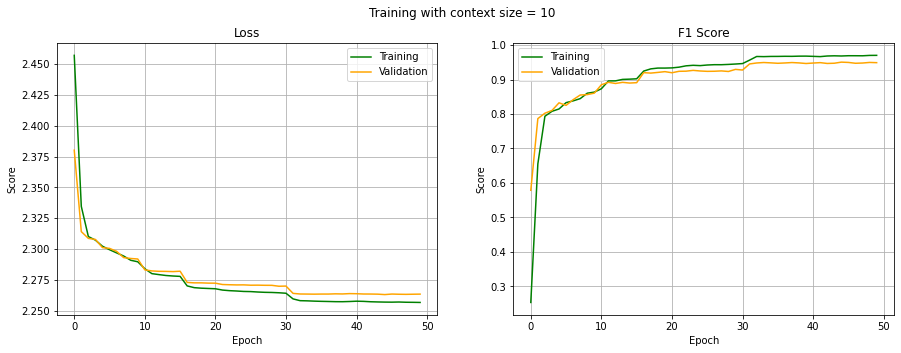

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9698, device='cuda:0'),
 tensor(0.9484, device='cuda:0'),
 tensor(0.9489, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9698, device='cuda:0'),
 tensor(0.9484, device='cuda:0'),
 tensor(0.9489, device='cuda:0'))

## Heatmap

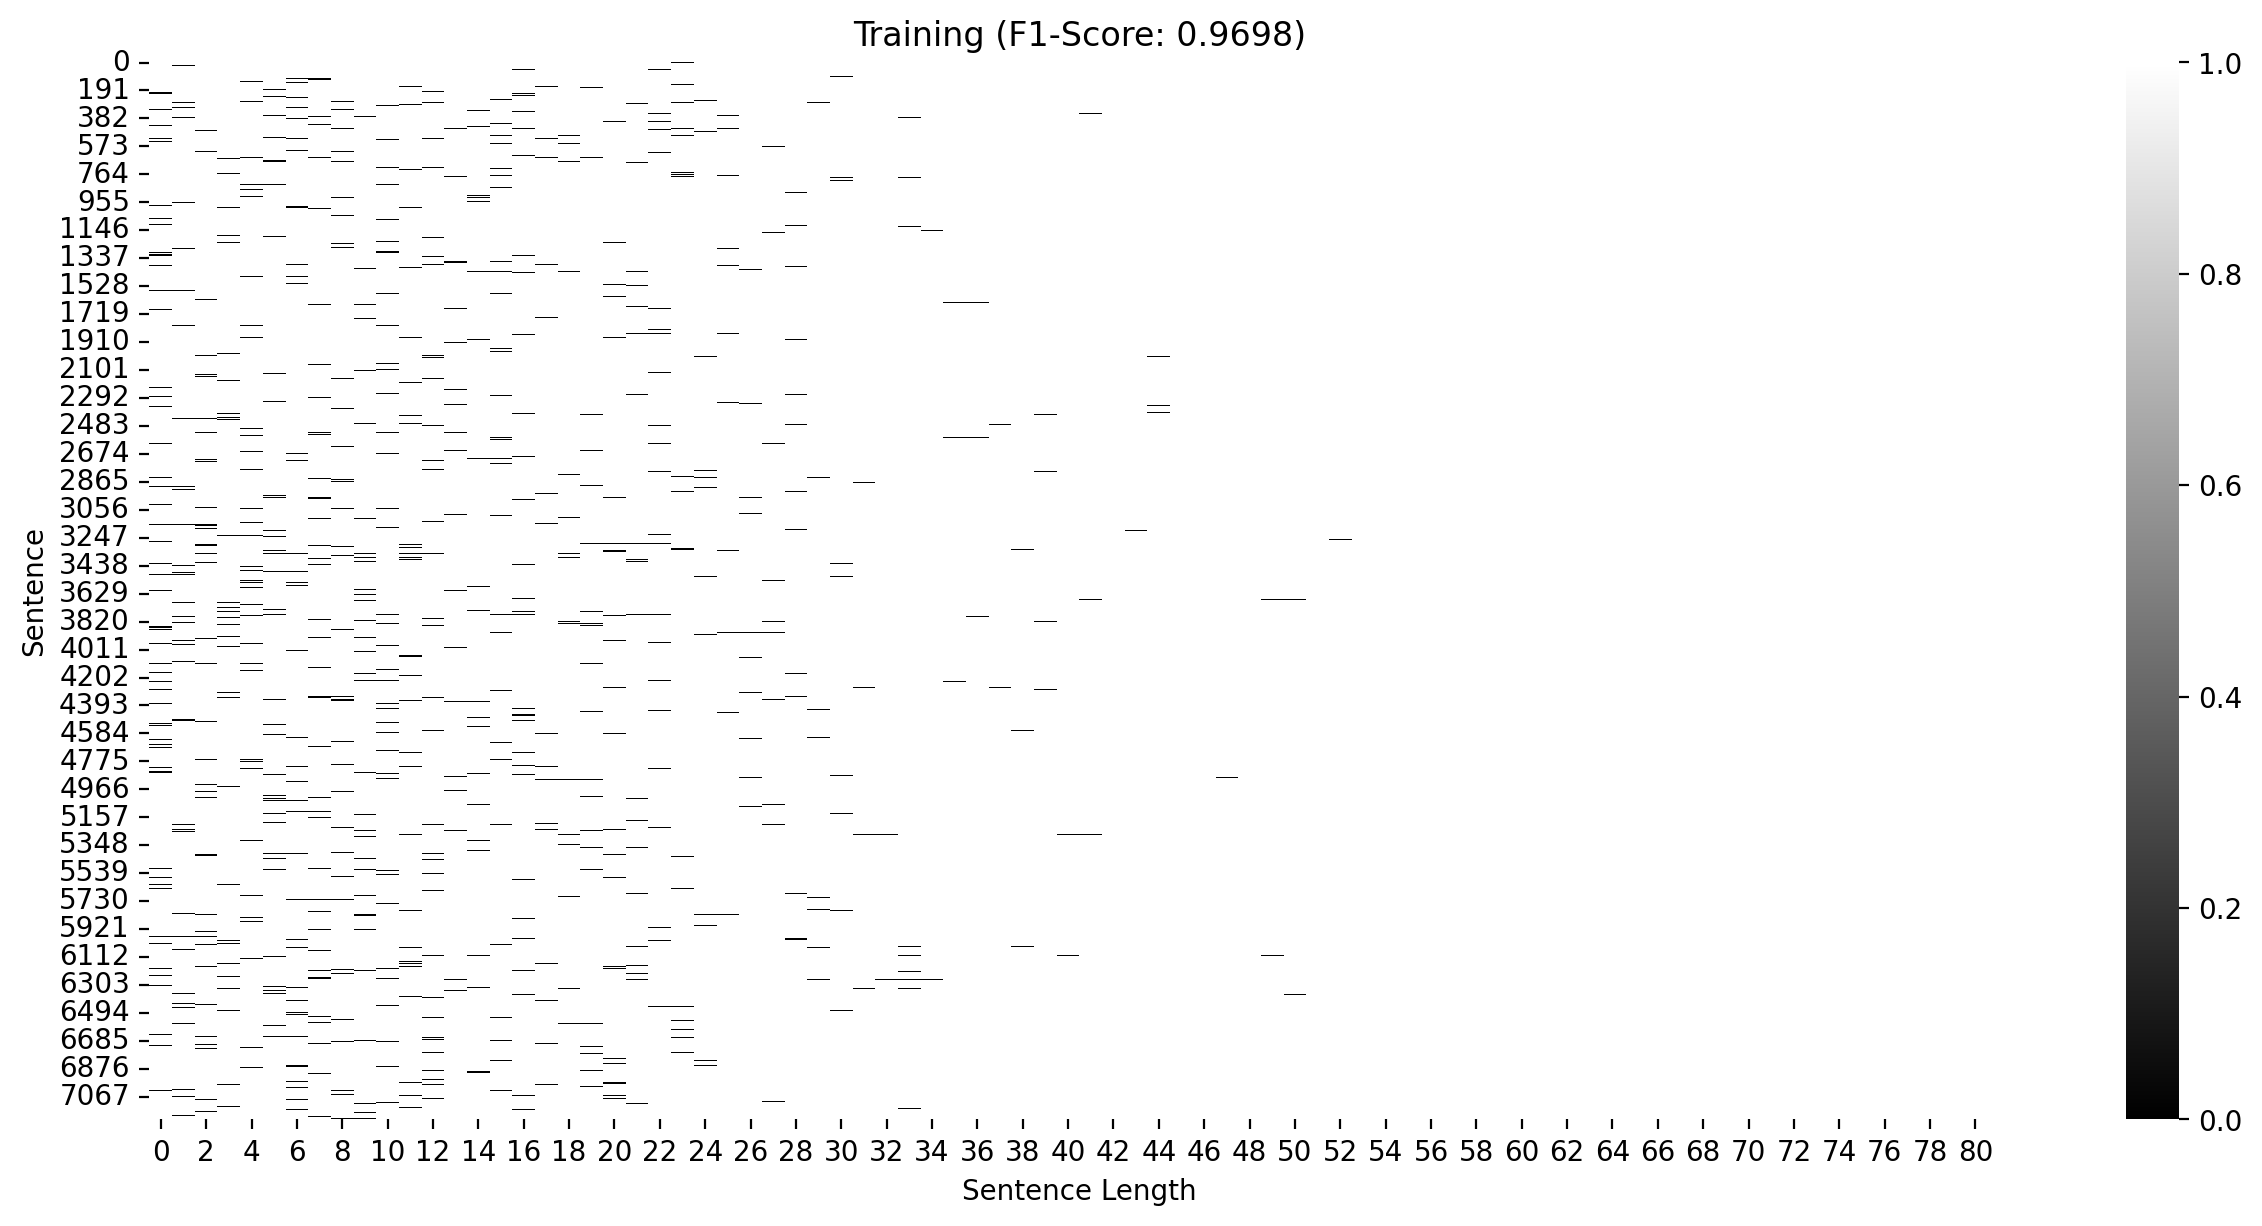

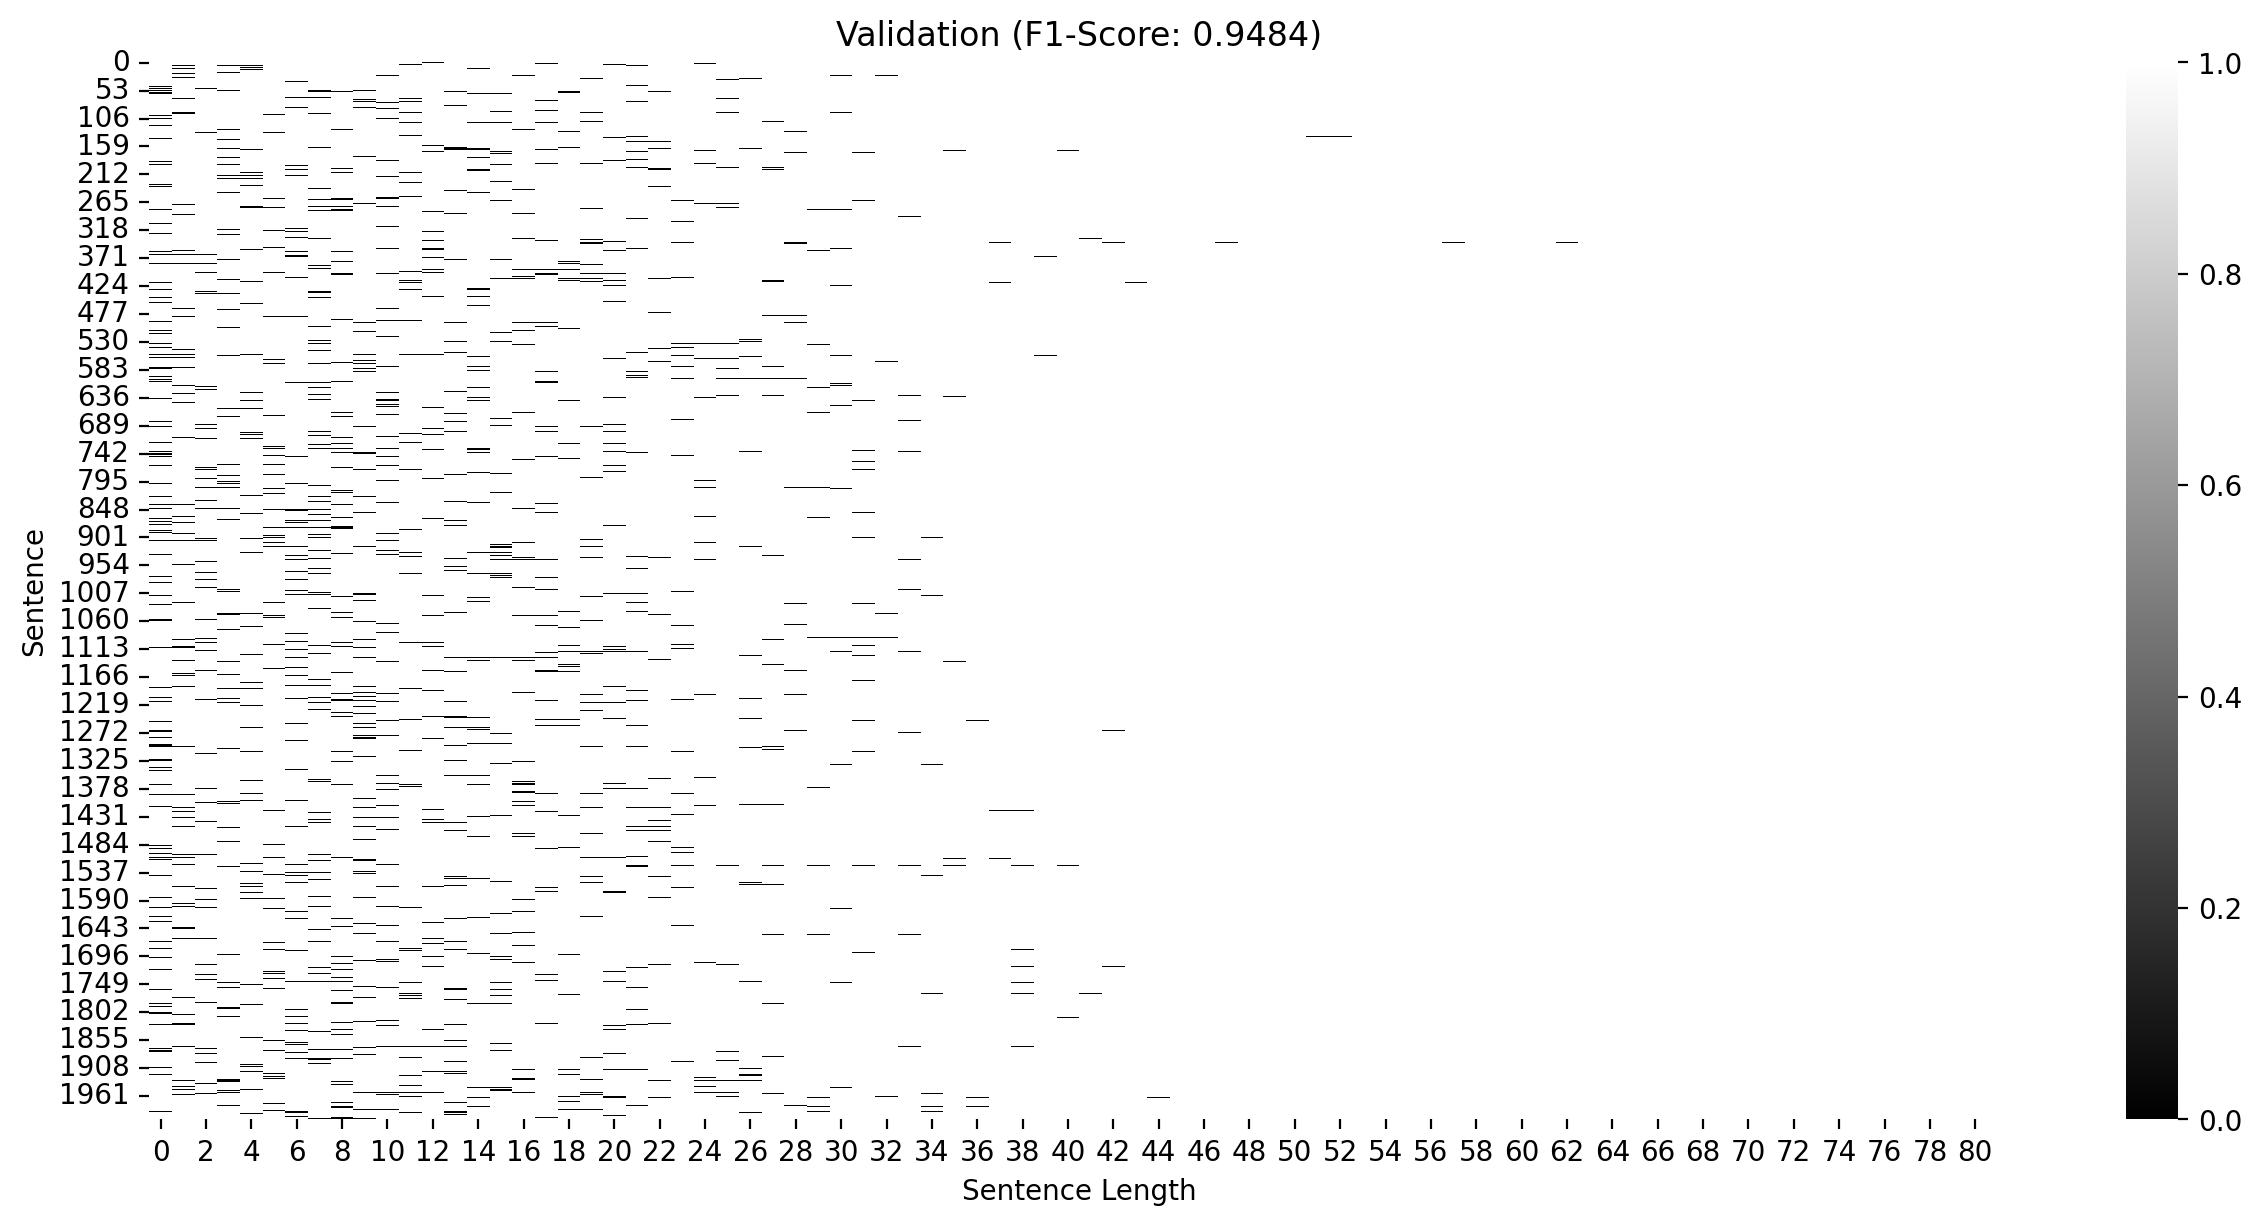

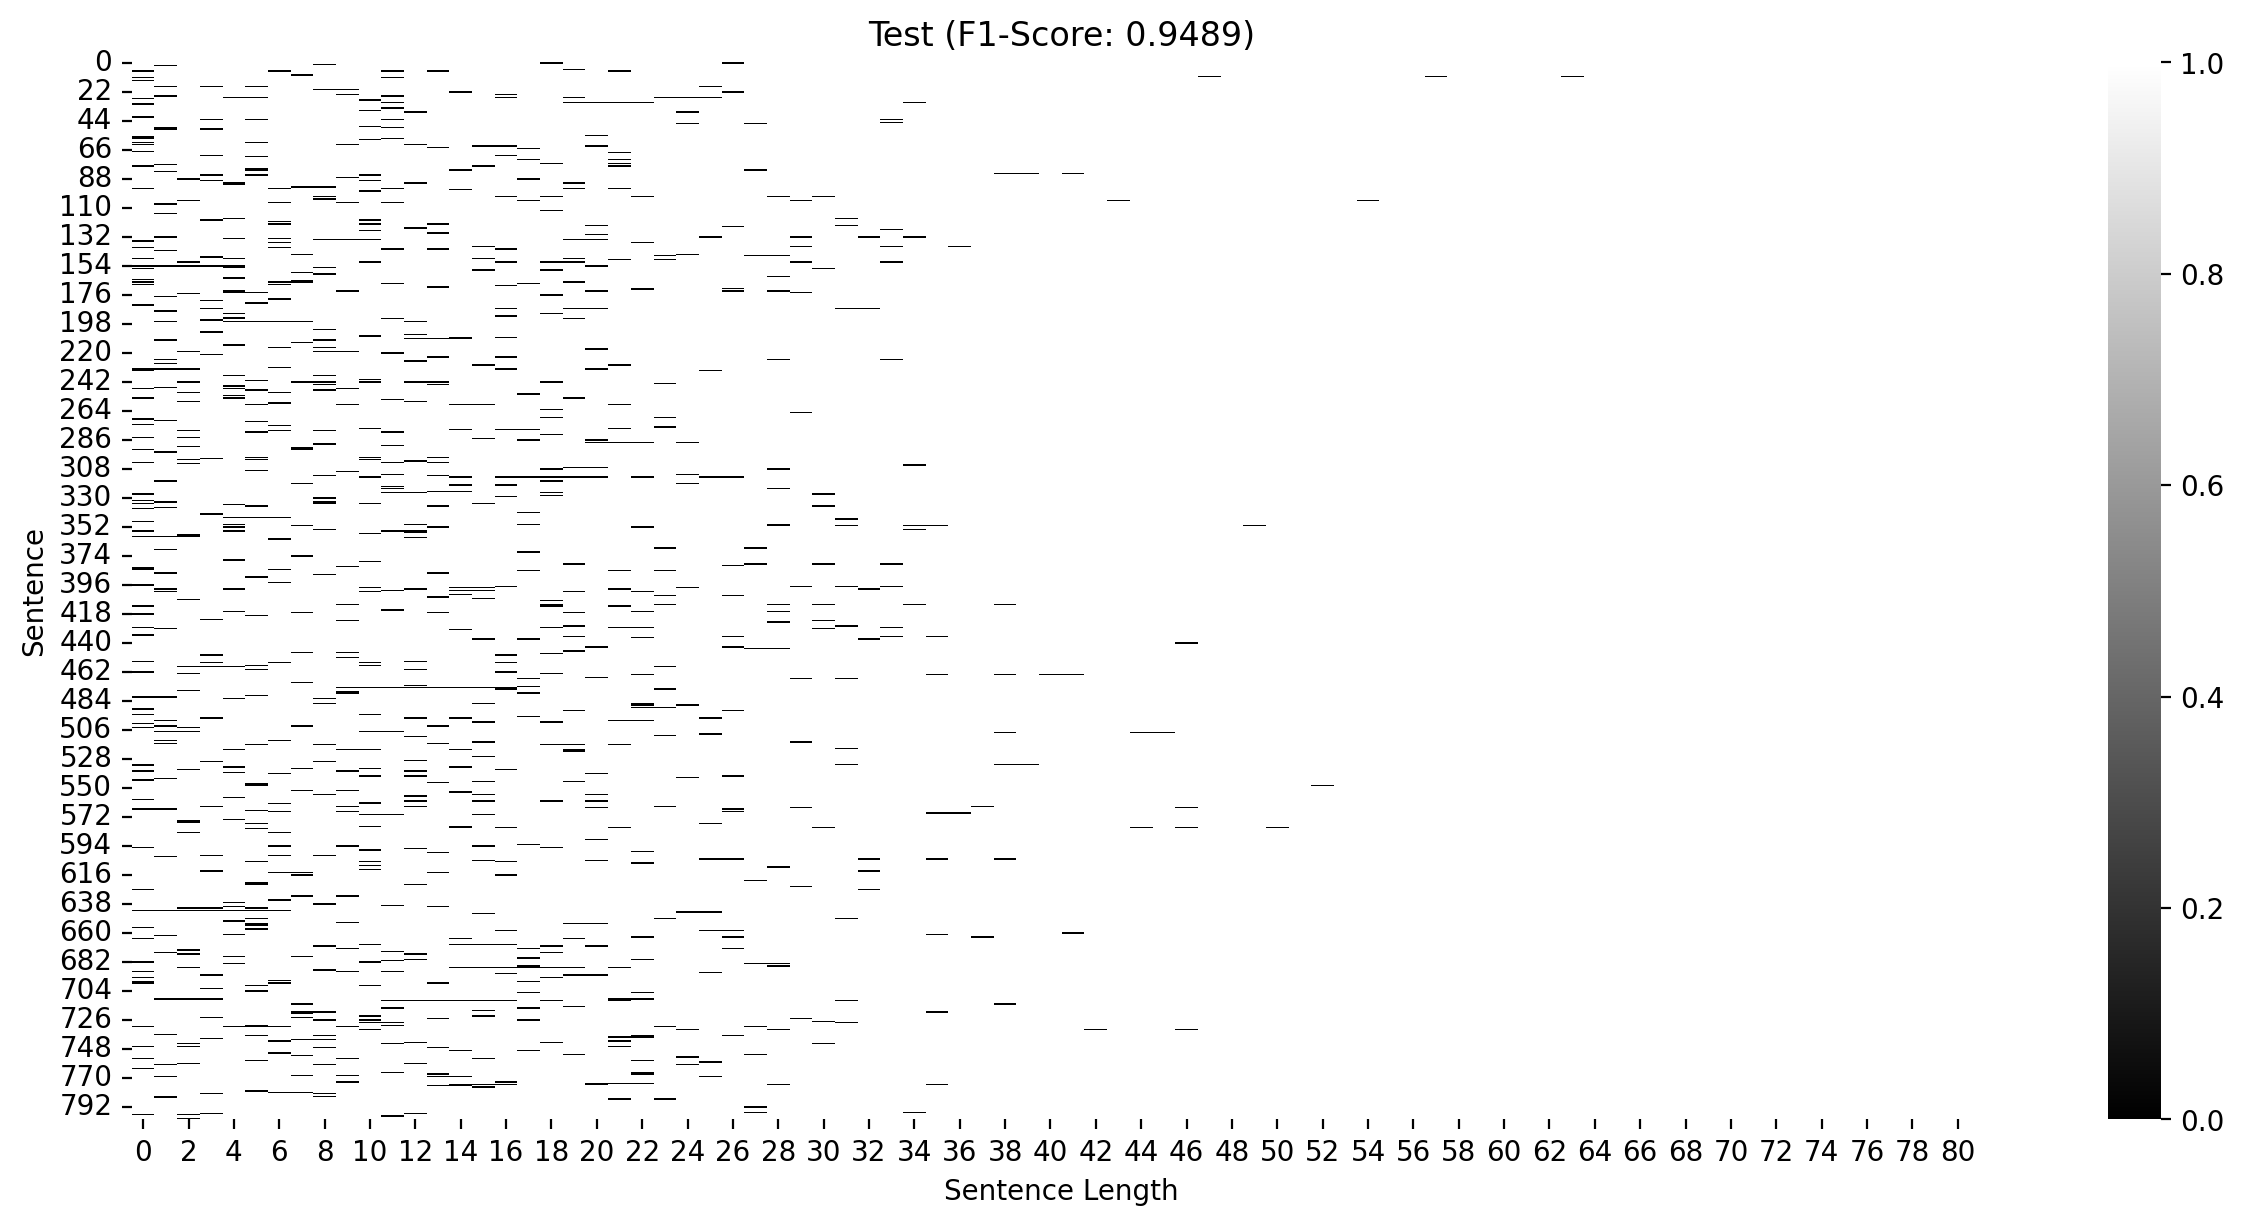

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


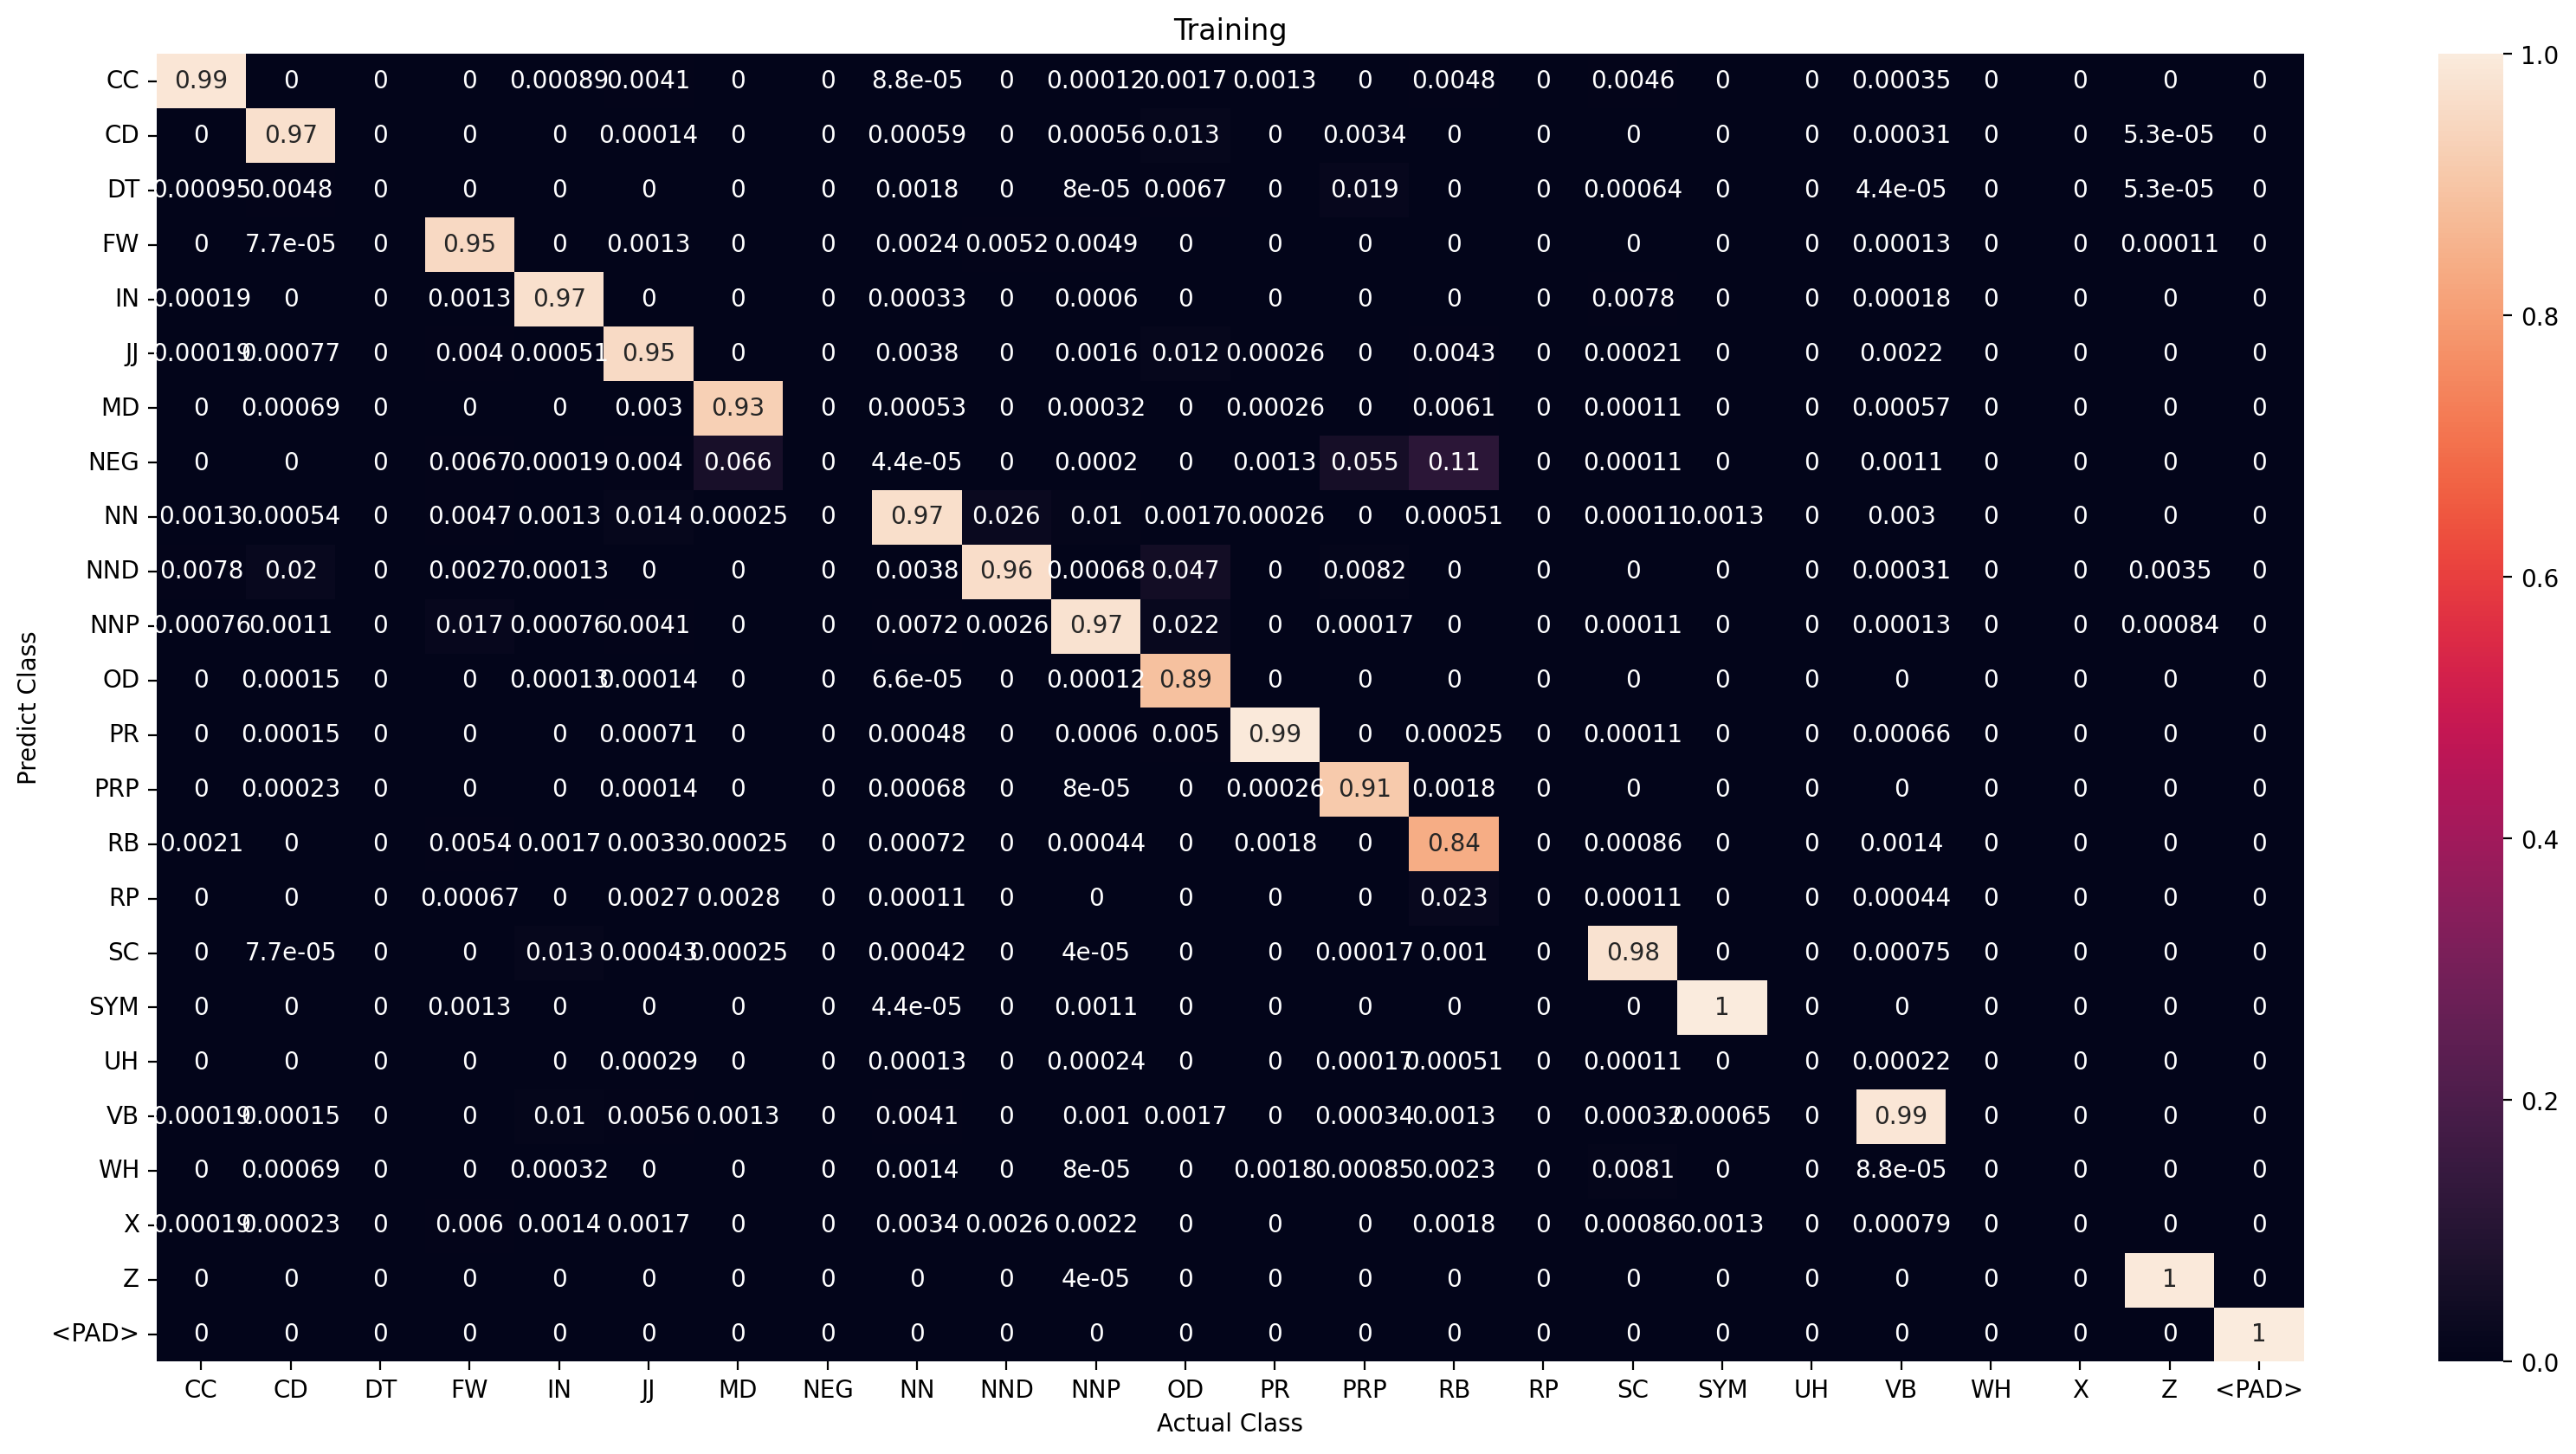

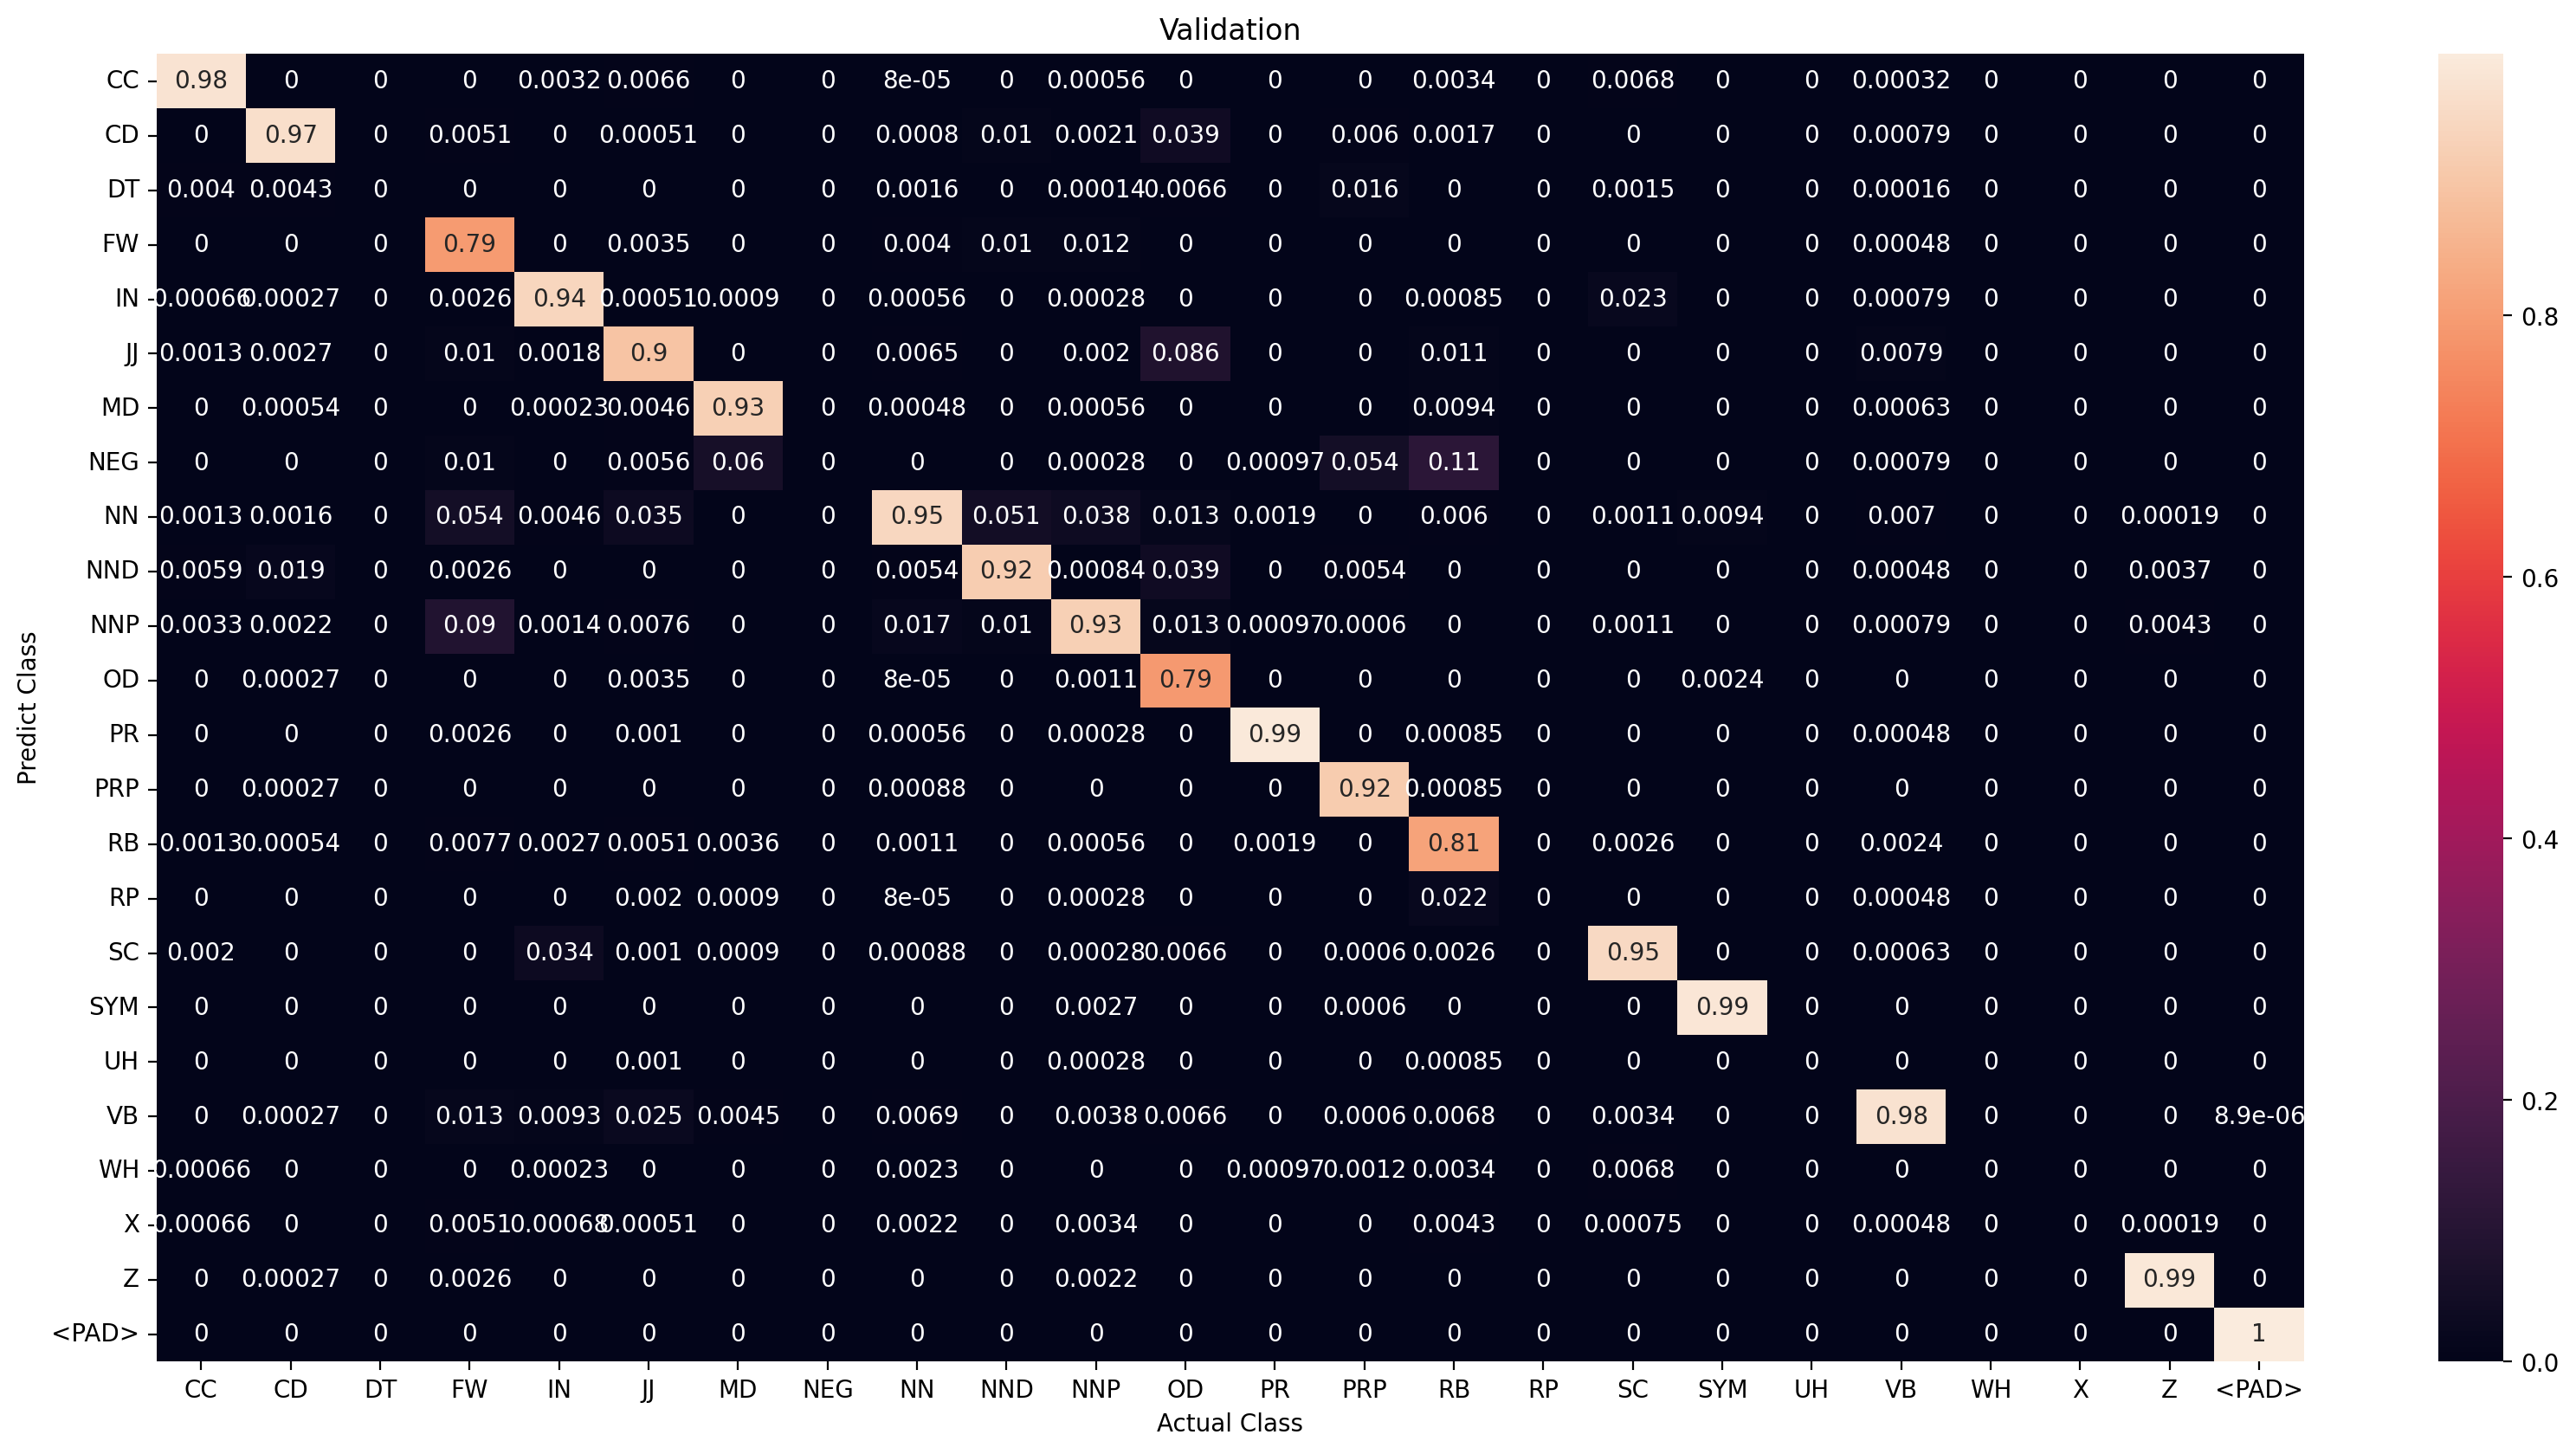

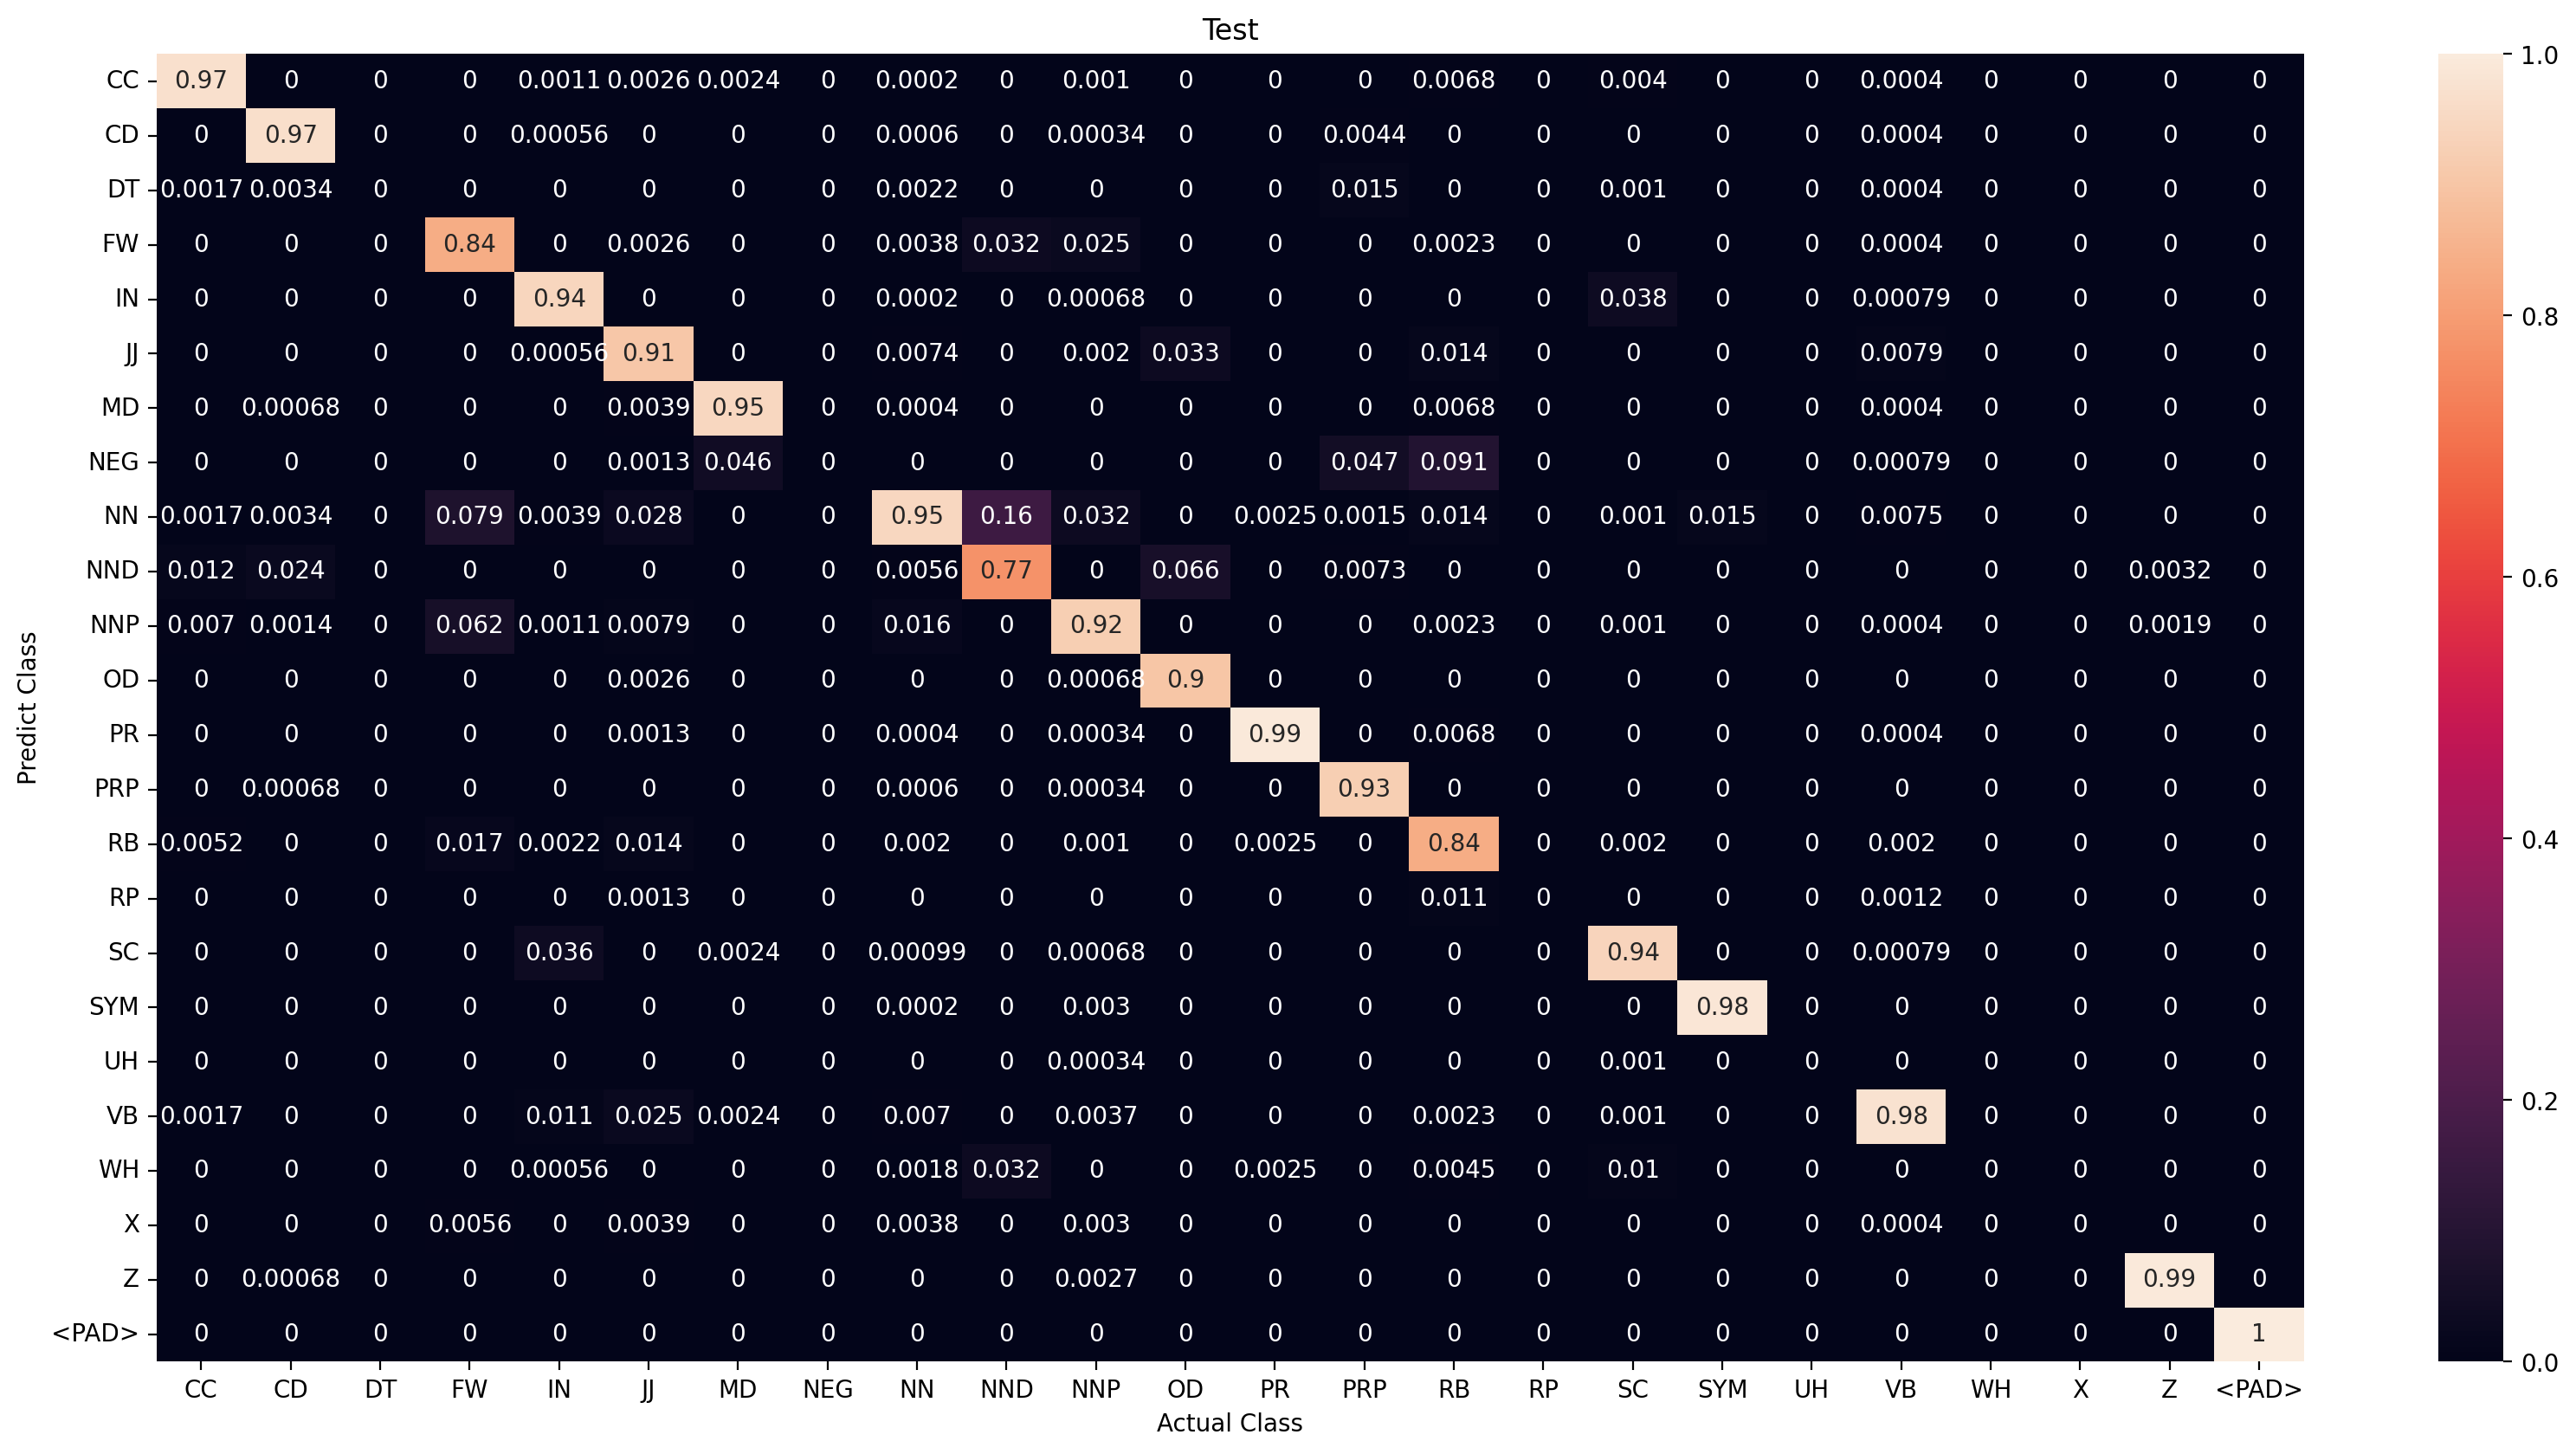

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5196       | CC    : 126      |
| CD    : 12758  | CD    : 12680      | CD    : 78       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1416       | FW    : 250      |
| IN    : 15371  | IN    : 15261      | IN    : 110      |
| JJ    : 6997   | JJ    : 6683       | JJ    : 314      |
| MD    : 3774   | MD    : 3673       | MD    : 101      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44189      | NN    : 483      |
| NND   : 1021   | NND   : 373        | NND   : 648      |
| NNP   : 24845  | NNP   : 24398      | NNP   : 447      |
| OD    : 541    | OD    : 530        | OD    : 11       |
| PR    : 3896   | PR    : 3832       | PR    : 64       |
| PRP   : 5408   | PRP   : 5363       | PRP   : 45       |
| RB    : 3463   | RB    : 3303       | RB    : 160      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19,  8,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11116
Wrong prediction            : 705
Percentage correct oov pred : 94.03603756027408

Validation
Number OOV token            : 3350
Correct prediction          : 2971
Wrong prediction            : 379
Percentage correct oov pred : 88.68656716417911

Test
Number OOV token            : 1391
Correct prediction          : 1252
Wrong prediction            : 139
Percentage correct oov pred : 90.00718907260963



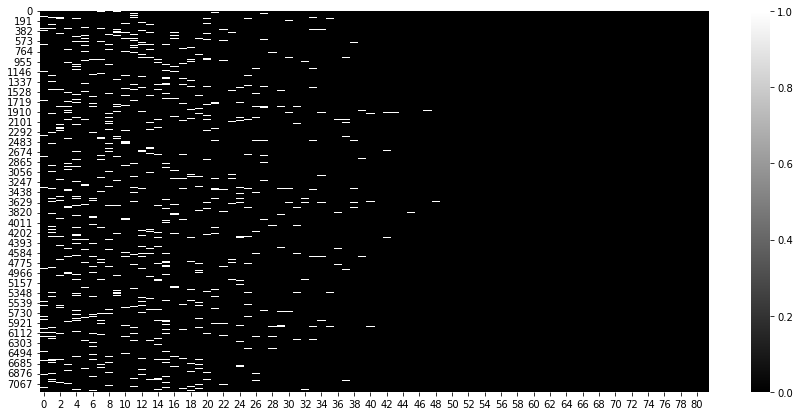

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

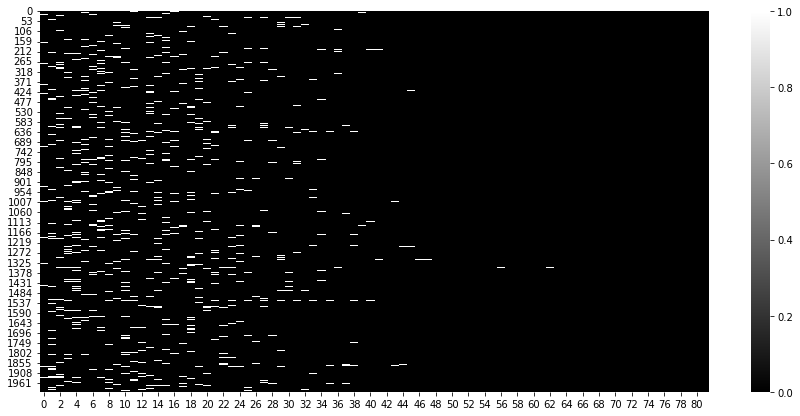

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

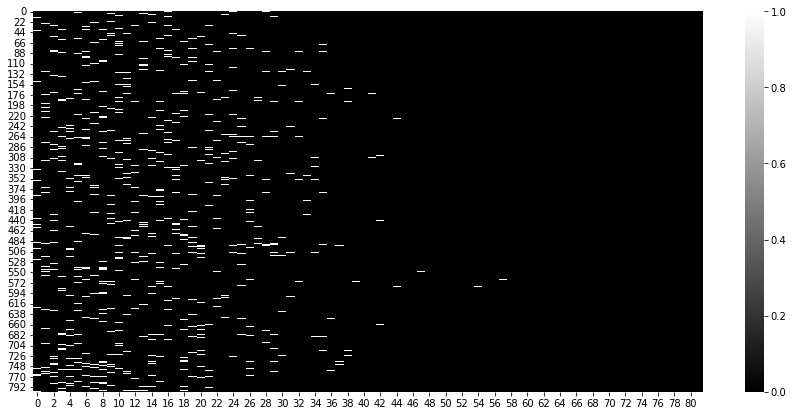

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);